# Build a Hidden Markov Model Stock Excess Growth Rate for One Minute Aggregates
This advanced example will build upon the previous example and will give students practice building an Observable Markov Model (OMM) of the excess growth rate of a ticker `SPY` using one-minute aggregate data (instead of daily data). The excess growth:
$$
\begin{equation*}
R_{ij} = \left(\frac{1}{\Delta{t}}\right)\cdot\ln\left(\frac{S_{i,j}}{S_{i,j-1}}\right) - \bar{r}_{f}
\end{equation*}
$$
is a scaled return, assuming continuous compounding. The quantity $R_{ij}$ denotes the excess growth rate of equity $i$ at time $j$ (units: 1/year), $\Delta{t}$ denotes the time-step between $j-1\rightarrow{j}$ (units: years), $S_{i,\star}$ denotes the share price of equity $i$ at time $\star$, and $\bar{r}_{f}$ denotes the annualized risk free rate.

Describe the minute-to-minute variation of the excess growth using a fully observable Markov model $\mathcal{M}$ represented by the tuple $\mathcal{M} = (\mathcal{S},\mathcal{O},\mathbf{P},\mathbf{E})$; $\mathcal{S}$ is the set of hidden states, $\mathcal{O}$ is the set of observable states, $\mathbf{T}$ is the transition matrix and $\mathbf{E}$ is the emission matrix. Because we are fully observable, the emission matrix $\mathbf{E} = \mathbf{I}$, where $\mathbf{I}$ is the identity matrix.

## Learning objectives
* __Task 1__: Construct the states $\mathcal{S}$, the emission matrix $\mathbf{E}$ and transition matrix $\hat{\mathbf{T}}$.
    * Estimate the transition matrix $\hat{\mathbf{T}}$ from market data
* __Task 2__: Simulate the Hidden Markov Model (HMM) for approximately one trading year in one-minute aggregates
    * Generate the stationary distribution from the estimated $\hat{\mathbf{T}}$ matrix
    * Implement the `MARKOV-SIMULATION` pseudo code from the lecture to generate hypothetical return sequences

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [1]:
include("Include.jl");

## Prerequisites: Constants and process the one-minute aggregate share price data
Before we set up the Markov model, we set some constant values that we'll use throughout the rest of the notebook. Then, we'll load and process the 1-minute aggregate share price data for `SPY.`

### Constants

In [2]:
risk_free_rate = 0.0421; # 17-Jun-2024 10-year treasury
Δt = (1/390)*(1/252); # 1-min aggregate trading periods in units of years
ticker = "SPY";

### Load and process `SPY` data
The `SPY` data used in this project (the entire 2023 trading year) was downloaded from [oneminutedata.com](https://oneminutedata.com). The `SPY` dataset, which is stored as a [comma-separated value (CSV) file](https://en.wikipedia.org/wiki/Comma-separated_values), is loaded using the [read method exported by the CSV.jl package](https://github.com/JuliaData/CSV.jl) as a [DataFrame instance](https://github.com/JuliaData/DataFrames.jl). We save the `SPY` data in the `share_price_data_df::DataFrame` variable:

In [3]:
share_price_data_df = CSV.read(joinpath(_PATH_TO_DATA, "SPY-OHLC-1-min-aggregate-2023.csv"), DataFrame)

Row,date,open,high,low,close,volume
,String31,Float64,Float64,Float64,Float64,Int64
1,2023-01-03 09:30:00,384.37,384.46,383.97,384.13,575276
2,2023-01-03 09:31:00,384.13,384.13,383.59,383.96,293800
3,2023-01-03 09:32:00,383.99,384.42,383.99,384.154,289329
4,2023-01-03 09:33:00,384.16,385.08,384.15,385.07,300648
5,2023-01-03 09:34:00,385.06,385.12,384.47,384.51,246156
6,2023-01-03 09:35:00,384.54,384.99,384.53,384.755,230167
7,2023-01-03 09:36:00,384.75,384.78,384.325,384.53,119297
8,2023-01-03 09:37:00,384.54,384.855,384.375,384.741,129655
9,2023-01-03 09:38:00,384.71,384.89,384.61,384.79,120879


Next, compute the [volume weighted average price](https://en.wikipedia.org/wiki/Volume-weighted_average_price#:~:text=In%20finance%2C%20volume%2Dweighted%20average,trading%20price%20for%20the%20period.) using the [vwap function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.vwap) for the `share_price_data_df::DataFrame.` We then compute the growth rate, i.e., time-scaled annualized return using [the `log_growth_matrix(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix), where $\Delta{t}$ denotes the trading period, i.e., 1-minute in units of years. We save growth rate data in the `Rᵢ::Array{Float64,1}` array, where each row holds the growth rate for that trading time period:

In [4]:
Rᵢ = vwap(share_price_data_df)|> data -> log_growth_matrix(data, Δt = Δt)

96879-element Vector{Float64}:
 -25.370811956266607
   6.433212218622656
  34.47544744550597
  16.70915720871667
  13.550730179623784
   2.661297195665073
   4.2649203762947865
   4.967265992331227
  16.829867852257006
  24.785890818294575
  40.51341066698778
  33.242673507082735
  20.23424653772622
   ⋮
   0.3406377163070191
   0.3162875911374961
   0.6446669742260449
   0.5396951870740953
   0.3922352799593621
   0.2880388669883392
   0.7142093136693322
   0.718297201272962
   0.4765247924607921
   0.6185536977465691
   1.011400876667081
   5.916606670551687

## Task 1: Construct the states $\mathcal{S}$, the emission matrix $\mathbf{E}$ and transition matrix $\hat{\mathbf{T}}$
First, consider the states $\mathcal{S}$. Suppose we put a label (and number) the excess return values, ranging from `super bad = 1,` $\dots$,` unchanged,` $\dots$,` super good = N,` where if $R\ll{0}$, then we are in the `super bad = 1,` state or $R\gg{0}$ we are in the `super good = N` state (or we are someplace in between). 
* __Idea__: Use the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) computed from the observed return series $R_{i,1}, \dots, R_{i,n}$ to partition the actual (historical) excess growth rates into one of a fixed number of categories. Once we have the categories, compute the probability that category $i$ on the day $k$ is followed by category $j$ on the day $k+1$. These values are entries in the state transition matrix $\hat{\mathbf{T}}$.
* To start, specify a value for the  `number_of_states` variable, where the `number_of_states` controls how many categories we are using when splitting up the excess return time series. We then set the `states` vector, which holds the states (numbered from `1`$\rightarrow$`number_of_states`). 

In [5]:
number_of_states = 1500; # TODO: specify a value here
states = range(1,stop=number_of_states) |> collect;

The `states` are hidden from the observer. Next, we set up the emissions matrix $\mathbf{E}$. For this example, because the states are __fully observable__, i.e., we can see the states directly,  the emission matrix $\mathbf{E}$ is the identity matrix $\mathbf{I}$:

In [6]:
E = diagm(ones(number_of_states));

### TODO: Estimate the transition matrix $\hat{\mathbf{T}}$ from market data
To estimate the transition matrix $\hat{\mathbf{T}}$, we'll estimate the transition probabilities from the excess return data calculated in the `Prerequisites` section and saved in the `Rᵢ` variable:
* Split the data into two blocks: the first (which we'll call the `in_sample_dataset`) will be used to estimate the elements of the matrix $\hat{\mathbf{T}}$, while the second (which we'll call `out_of_sample_dataset`) will be used for testing purposes (later). The fraction of data partitioned into the training dataset is controlled by the `split_fraction` variable.

Set a value for the `split_fraction` variable:

In [7]:
split_fraction = 0.90; # TODO: specify a value here
insample_end_index = round(split_fraction*length(Rᵢ), digits=0) |> Int
in_sample_dataset = Rᵢ[1:insample_end_index]
out_of_sample_dataset = Rᵢ[(insample_end_index+1):end];

Next, we need to model the return data distribution to compute the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function). The excess return distribution is a random variable that follows some [probability distribution function](https://en.wikipedia.org/wiki/Probability_distribution). We don't know what that distribution function is, but for now, we assume the excess returns follow a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution)
* We use the [fit_mle function](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl) to fit a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) to our our data. We fit the distribution to the full dataset `Rₘ` and save the distribution in the `d` variable.

In [8]:
d = fit_mle(Laplace, Rᵢ); # use the *full* data set to establish the cutoff's

Next, we generate the percentile cutoffs that we use to establish the bounds that correspond to each category of return, i.e., `super bad` or `super good`, etc.

In [9]:
percentage_cutoff = range(0.0,stop=1.0,length=(number_of_states+1)) |> collect;

Now that we have the cutoffs, compute the lower and upper bound for each potentiual category. To do this, we'll use the [quantile function](https://juliastats.org/Distributions.jl/stable/univariate/#Statistics.quantile-Tuple{UnivariateDistribution,%20Real}) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl). For a given `0 ≤ q ≤ 1`, `quantile(d, q)` is the smallest value `x` 
for which `cdf(d, x) ≥ q`.

In [10]:
bounds = Array{Float64,2}(undef, number_of_states, 3)
for s ∈ states
    bounds[s,1] = quantile(d,percentage_cutoff[s])
    bounds[s,2] = quantile(d,percentage_cutoff[s+1])
    bounds[s,3] = s
end
bounds

1500×3 Matrix{Float64}:
 -Inf        -0.749492     1.0
  -0.749492  -0.664741     2.0
  -0.664741  -0.615165     3.0
  -0.615165  -0.57999      4.0
  -0.57999   -0.552706     5.0
  -0.552706  -0.530414     6.0
  -0.530414  -0.511566     7.0
  -0.511566  -0.495239     8.0
  -0.495239  -0.480838     9.0
  -0.480838  -0.467955    10.0
  -0.467955  -0.456302    11.0
  -0.456302  -0.445663    12.0
  -0.445663  -0.435876    13.0
   ⋮                    
   0.565549   0.576188  1489.0
   0.576188   0.587842  1490.0
   0.587842   0.600724  1491.0
   0.600724   0.615125  1492.0
   0.615125   0.631452  1493.0
   0.631452   0.6503    1494.0
   0.6503     0.672593  1495.0
   0.672593   0.699876  1496.0
   0.699876   0.735051  1497.0
   0.735051   0.784627  1498.0
   0.784627   0.869378  1499.0
   0.869378  Inf        1500.0

Now that we have the category bounds, let's take the excess return data and determine which state an excess return observation corresponds to. For each sample in the `in_sample_dataset`:
* Classify the sample value into one of the possible categories. Let `state = 1` equal the worst return, and `state = number_of_states` equal the best return. Save these results in the `encoded_in_sample` array:

In [11]:
encoded_in_sample = Array{Int64,1}();
for i ∈ eachindex(in_sample_dataset)
    value = in_sample_dataset[i];

    class_index = 1;
    for s ∈ states
        if (bounds[s,1] ≤ value && value < bounds[s,2])
            class_index = s;
            break;
        end
    end
    push!(encoded_in_sample, class_index);
end
encoded_in_sample;

In the matrix $\mathbf{T}$ compute the `counts` for transition from state `i` to state `j`:

In [12]:
T = zeros(number_of_states, number_of_states)
for i ∈ 2:insample_end_index
    start_index = encoded_in_sample[i-1];
    stop_index = encoded_in_sample[i];
    T[start_index,stop_index] += 1;
end
T

1500×1500 Matrix{Float64}:
 307.0  14.0  10.0  13.0  5.0  6.0  …   0.0   0.0   1.0   0.0   0.0    1.0
  15.0   3.0   3.0   4.0  1.0  3.0      0.0   0.0   0.0   0.0   0.0    0.0
   8.0   5.0   2.0   3.0  3.0  1.0      0.0   0.0   0.0   0.0   0.0    0.0
  11.0   5.0   5.0   2.0  0.0  1.0      0.0   0.0   0.0   0.0   0.0    0.0
   8.0   1.0   1.0   2.0  1.0  0.0      0.0   0.0   0.0   0.0   0.0    0.0
   2.0   1.0   3.0   2.0  1.0  3.0  …   0.0   0.0   0.0   0.0   0.0    0.0
   1.0   1.0   0.0   1.0  2.0  1.0      0.0   0.0   0.0   0.0   0.0    0.0
   4.0   2.0   1.0   1.0  2.0  0.0      0.0   0.0   0.0   0.0   0.0    0.0
   0.0   1.0   0.0   1.0  0.0  0.0      0.0   0.0   0.0   0.0   0.0    0.0
   2.0   0.0   1.0   0.0  0.0  0.0      0.0   0.0   0.0   0.0   0.0    0.0
   2.0   2.0   0.0   1.0  0.0  0.0  …   0.0   0.0   0.0   0.0   0.0    0.0
   3.0   0.0   2.0   0.0  1.0  0.0      0.0   0.0   0.0   0.0   0.0    0.0
   0.0   0.0   1.0   0.0  0.0  0.0      0.0   0.0   0.0   0.0   0.0    0.

From the `counts` matrix $\mathbf{T}$, compute the transtion probability matrix $\hat{\mathbf{T}}$:

In [13]:
T̂ = zeros(number_of_states, number_of_states)
for row ∈ states
    Z = sum(T[row,:]);
    for col ∈ states
        T̂[row,col] = (1/Z)*T[row,col]
    end
end
T̂

1500×1500 Matrix{Float64}:
 0.777215    0.035443   0.0253165  …  0.0        0.0        0.00253165
 0.319149    0.0638298  0.0638298     0.0        0.0        0.0
 0.210526    0.131579   0.0526316     0.0        0.0        0.0
 0.297297    0.135135   0.135135      0.0        0.0        0.0
 0.275862    0.0344828  0.0344828     0.0        0.0        0.0
 0.0769231   0.0384615  0.115385   …  0.0        0.0        0.0
 0.0588235   0.0588235  0.0           0.0        0.0        0.0
 0.2         0.1        0.05          0.0        0.0        0.0
 0.0         0.05       0.0           0.0        0.0        0.0
 0.111111    0.0        0.0555556     0.0        0.0        0.0
 0.0909091   0.0909091  0.0        …  0.0        0.0        0.0
 0.136364    0.0        0.0909091     0.0        0.0        0.0
 0.0         0.0        0.0833333     0.0        0.0        0.0
 ⋮                                 ⋱                        
 0.0         0.0        0.0           0.0416667  0.03125    0.104167
 0.0

## Task 2: Simulate the Hidden Markov Model (HMM)
To do the simulation, we first build a [`MyHiddenMarkovModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.MyHiddenMarkovModel), which holds the data for our Markov model. We use a [`build(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.build-Tuple{Type{MyHiddenMarkovModel},%20NamedTuple}), which takes information about the `states,` the estimated transition matrix $\hat{\mathbf{T}}$, and the emission matrix $\mathbf{E}$ and returns a [`MyHiddenMarkovModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.MyHiddenMarkovModel), which we save in the `model` variable.

In [14]:
model = build(MyHiddenMarkovModel, (
    states = states,
    T = T̂, 
    E = E
));

### TODO: Generate the stationary distribution from the estimated $\hat{\mathbf{T}}$ matrix
Generate the stationary distribution for the estimated transition matrix $\hat{\mathbf{T}}$ and use it to construct a [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) representing the stationary distrubution, save the [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) in the `π̄`-variable:

In [15]:
power_value = 50;
π̄ = (T̂^power_value) |> tmp -> Categorical(tmp[1,:]); # TODO: compute the stationary distribution (approx value is ok)

#### Check: Are you really at the stationary distribution?
To compute the stationary distribution $\bar{\pi}$, we raise the transition matrix $\hat{\mathbf{T}}$ to the power of `power_value.` However, we don't know the value of `power_value` _a priori_. 
* We can test different values for `power_value` using the fact that stationary distribution is a rank one matrix. Thus, we can estimate the minimum value of `power_value` such that `T̂^power_value` has `rank = 1` and check this condition [using the Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert).

In [16]:
@assert ((T̂^power_value) |> rank ) == 1

LoadError: AssertionError: T̂ ^ power_value |> rank == 1

### TODO: Implement the `MARKOV-SIMULATION` pseudo code to generate hypothetical return sequences
*Generate 'number_of_paths' example sequences, each containing 'number_of_steps' days. These variables determine the length and number of our hypothetical return sequences. Assume each path starts from a draw from the stationary distribution `π̄.`
* Save the simulated return sequences in the `archive::Array{Int64,2}(undef, number_of_steps, number_of_paths)` array, where the `row` index corresponds to a path, and the `col` index corresponds to a day.
* We have implemented some shortcut logic to speed up the implementation. To evaluate the Markov model for a `number_of_steps,` issue the command `model(start_state, number_of_steps).` This will compute a chain with `number_of_steps` entries starting as `start_state` and return the simulated sequence as an `array.` 

In [17]:
number_of_paths = 100;
number_of_steps = insample_end_index; # average number of trading days per year
encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
for i ∈ 1:number_of_paths
    start_state = rand(π̄);
    tmp = model(start_state, number_of_steps)
    for j ∈ 1:number_of_steps
        encoded_archive[j,i] = tmp[j]
    end
end
encoded_archive

87191×100 Matrix{Int64}:
  977   699    86   423  448   66  1492  …  425   429  140   198  226  363
  788   705   126   374  434  243  1472     440   412   92   105  127  382
  905   570   158   318  436  213  1485     430   311  139   134   62  375
  696   819   239   407  442  267  1475     432   219  191   129  123  324
  669   794   222   418  444  133  1495     403   337  126    74   80  383
  562  1048   209   431  429  240  1393  …  411   336  174   131  121  401
  579  1329   233   446  364  225   829     422   384  175    85    5  408
  999  1239   267   442  422  291   896     394   320   14   198   36  408
 1028  1115   267   442  435  299   967     343   343   52   296   34  405
  591  1267   202   436  434  265  1052     317   317   67   371   22  424
  596  1175   196   420  438  307   953  …  298   342   88   358    7  448
  969   910   214   399  430  214   639     329   336   46   366    1  450
 1297   807   555   390  431  202   621     348   300   20   384    1  447


In [18]:
actual_sample_bounds = copy(bounds);
actual_sample_bounds[1,1] = minimum(in_sample_dataset);
actual_sample_bounds[end,2] = maximum(in_sample_dataset)
actual_sample_bounds

1500×3 Matrix{Float64}:
 -25.3708    -0.749492     1.0
  -0.749492  -0.664741     2.0
  -0.664741  -0.615165     3.0
  -0.615165  -0.57999      4.0
  -0.57999   -0.552706     5.0
  -0.552706  -0.530414     6.0
  -0.530414  -0.511566     7.0
  -0.511566  -0.495239     8.0
  -0.495239  -0.480838     9.0
  -0.480838  -0.467955    10.0
  -0.467955  -0.456302    11.0
  -0.456302  -0.445663    12.0
  -0.445663  -0.435876    13.0
   ⋮                    
   0.565549   0.576188  1489.0
   0.576188   0.587842  1490.0
   0.587842   0.600724  1491.0
   0.600724   0.615125  1492.0
   0.615125   0.631452  1493.0
   0.631452   0.6503    1494.0
   0.6503     0.672593  1495.0
   0.672593   0.699876  1496.0
   0.699876   0.735051  1497.0
   0.735051   0.784627  1498.0
   0.784627   0.869378  1499.0
   0.869378  40.5134    1500.0

### Decode operation
To turn the state $s\in\mathcal{S}$ back into an excess return value, we need to __decode__ the state. To do this, let's construct a [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) describing the observed return values associated with each state in the `encoded_in_sample` dataset.
* We collect the observed excess return samples associated with a particular state $s$, store them in a `tmp` array, and use [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) to estimate a [Normal distribution exported from the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal)

In [19]:
decode_distribution_model = Dict{Int,Normal}()
for s ∈ states

    # what indexes correspond to state s
    index_collection_state_s = findall(x-> x == s, encoded_in_sample);
    tmp = Array{Float64,1}();
    for i ∈ index_collection_state_s
        decoded_value = Rᵢ[i];
        push!(tmp, decoded_value);
    end
    decode_distribution_model[s] = fit_mle(Normal,tmp);
end
decode_distribution_model;

Then, generate a random value for the excess return by sampling the appropriate [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). We develop `number_of_paths` trajectories, each containing `number_of_steps` values. We store these values in the `decoded_archive` variable:

In [20]:
in_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
for i ∈ 1:number_of_paths
    for j ∈ 1:number_of_steps
        s = encoded_archive[j,i];
        in_sample_decoded_archive[j,i] =  decode_distribution_model[s] |> d -> rand(d)
    end
end
in_sample_decoded_archive # actual excess growth value

87191×100 Matrix{Float64}:
 0.103875   0.051324   -0.205642   …  -0.103326   -0.0871587  -0.0289521
 0.0662811  0.0522391  -0.158739      -0.18149    -0.157691   -0.0226042
 0.0881792  0.0262595  -0.13079       -0.150967   -0.246161   -0.0248883
 0.0507537  0.0716942  -0.0800676     -0.155853   -0.161744   -0.0428157
 0.0457569  0.0672678  -0.0892211     -0.223333   -0.214758   -0.0224306
 0.0245257  0.121722   -0.0969328  …  -0.154444   -0.164275   -0.0167396
 0.0281548  0.240256   -0.0830411     -0.206958   -0.575006   -0.0146448
 0.109149   0.188744   -0.0664344     -0.102984   -0.313578   -0.0146326
 0.116408   0.141256   -0.0665209     -0.0538398  -0.321551   -0.0155811
 0.0306803  0.202663   -0.101062      -0.0262305  -0.376089   -0.00981449
 0.0316895  0.162067   -0.104309   …  -0.0308223  -0.524769   -0.00316275
 0.102122   0.0890854  -0.0936116     -0.0278365  -3.64018    -0.00255121
 0.219224   0.0694939   0.0230427     -0.021968    0.212352   -0.00346017
 ⋮                  

### Visualize simulated excess growth rate distribution

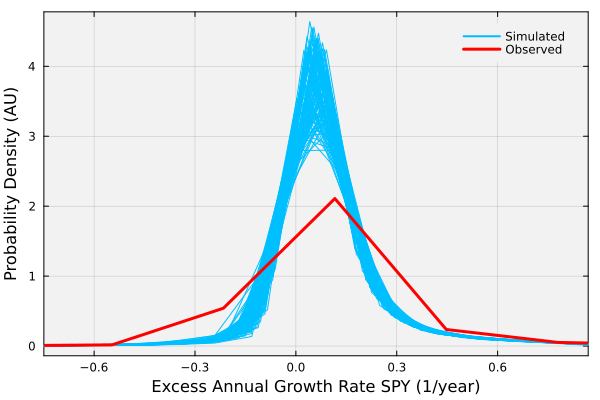

In [21]:
let
    q = plot(); 
    density!(in_sample_decoded_archive[:,1], lw=2, c=:deepskyblue1, label="Simulated", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, 
        xlims=(bounds[1,2], bounds[end,1]))
    for i ∈ 2:number_of_paths
        density!(in_sample_decoded_archive[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(in_sample_dataset, c=:red, lw=3, label="Observed")
    xlabel!("Excess Annual Growth Rate $(ticker) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

### Check: Are the predicted and observed return distributions the same? 
If our Markov model is correct, then the observed excess growth rate distribution and the excess growth distribution calculated by our model should look like they are drawn from the same distribution. To check this hypothesis, use [the ApproximateTwoSampleKSTest exported by the HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl) 
* `H0:null hypothesis` is that `x` and `y` are drawn from the same distribution against the `H1:alternative hypothesis` that `x` and `y` come from different distributions.

We have `number_of_paths` example trajectories, so let's do the test on each sample and compute an overall expected score. Specify a `pvalue_cutoff` value to check against. If the test returns `pvalue > pvalue_cutoff,` then we fail to reject `H0:null hypothesis`, i.e., `x` and `y` appear to be drawn from the same distribution.

In [22]:
pvalue_cutoff = 0.01; # 99% cutoff
pass_counter = 0;
for i ∈ 1:number_of_paths
    test_value = ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive[:,i]) |> pvalue
    if (test_value > pvalue_cutoff)
        pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
    end
end
println("Pass percentage: $((pass_counter/number_of_paths)*100)%")

Pass percentage: 15.0%


## Task 3: Save the HMM model and other data to a file
In the project and advanced example for this module, we'll use the hidden Markov Model (HMM) we developed here. Let's save the model to disk to save some time later. 
* Use the [save(...) method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl.git) to write the model in a binary format. First, we specify a `path` in the `path_to_save_file` variable: 

In [23]:
path_to_save_file = joinpath(_PATH_TO_DATA,"HMM-$(ticker)-1-min-aggregate.jld2");

Then we write an `HDF5 binary file` holding our data to the location specified by `path_to_save_file.` We use the [save(...) function exported by the JLD2.jl package to write a binary save file](https://github.com/JuliaIO/JLD2.jl.git) (later we'll use to the `load(...)` function to reload this data):

In [24]:
save(path_to_save_file, Dict("model"=>model, 
        "decode"=>decode_distribution_model, "stationary"=>π̄, 
        "insampledataset"=>in_sample_dataset, "outofsampledataset"=>out_of_sample_dataset));

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.